Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей.

Цель проекта: построить модель, которая по фотографии определит приблизительный возраст человека, для того чтобы анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы, а также контролировать добросовестность кассиров при продаже алкоголя.

Будем использовать метрику качества MAE (среднюю абсолютную ошибку).

## Исследовательский анализ данных

Импортируем нужные библиотеки и загрузим датасет

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
train_data = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


Промежуточный вывод: выборка небольшая 7591 фото, можем провести аугментацию данных. 

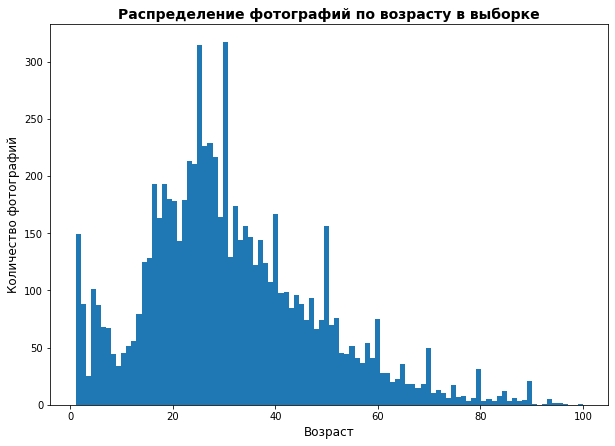

In [5]:
plt.figure(figsize=(10,7))
plt.hist(labels['real_age'], bins=100)
plt.title('Распределение фотографий по возрасту в выборке', fontsize=14, fontweight='bold')
plt.xlabel('Возраст', fontsize=12)
plt.ylabel('Количество фотографий', fontsize=12)
plt.show()

Промежуточный вывод: график не имеет вид нормального распределения. Наблюдаются выбросы в выборке: много фото младенцев в районе 1 года, а также людей в возрасте  25-ти и около 30 лет, а также около 50 лет.

In [6]:
features, target = next(train_data)

Выведем 15 фото с указанием возраста, чтобы посмотреть на имеющуюся выборку

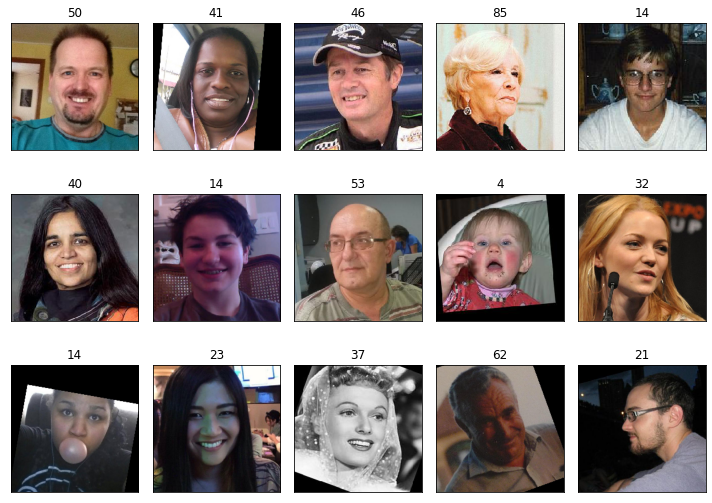

In [7]:
fig=plt.figure(figsize = (10, 8))
for i in range(15):
    fig.add_subplot(3, 5, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()  

Вывод: в результате проведенного EDA получили информацию о том, что размер выборки небольшой, поэтому при построении модели проведем аугментацию изображений. Количество фотографий распределено по возрасту неравномерно: много фото младенцев в районе 1 года, а также людей в возрасте 25-ти и около 30 лет, а также около 50 лет. В выборке есть фотографии, которые повернуты относительно центральной оси.

Можно рекомендовать для аугментации отразить фотографии по горизонтали, установить диапазон вращения в пределах +/- 20 градусов.

## Обучение модели

Код обучения модели:

```python

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Conv2D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator


def load_train(path):
    labels = pd.read_csv(path +'labels.csv')
    
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25, horizontal_flip=True)
    
    train_data_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory= path + '/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset = 'training',
        seed=12345) 
    
    return train_data_flow


def load_test(path):
    labels = pd.read_csv(path +'labels.csv')
    
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    
    test_data_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory= path + '/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset = 'validation',
        seed=12345) 
    
    return test_data_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False) # не будем замораживать верхние слои, размер выборки достаточный
    optimizer = Adam(lr=0.0001)
    model = Sequential()
    model.add(backbone)
    model.add(Flatten())
    model.add(Dense(units=100, activation='relu'))
    model.add(Dense(units=60, activation='relu'))
    model.add(Dense(units=1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data= test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    
    return model
```

Результат обучения модели:

```
Train for 178 steps, validate for 60 steps
Epoch 1/10
2023-04-15 11:34:28.155757: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-04-15 11:34:28.620107: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 63s - loss: 172.6159 - mae: 9.7878 - val_loss: 572.8345 - val_mae: 18.9168
Epoch 2/10
178/178 - 42s - loss: 67.7231 - mae: 6.1925 - val_loss: 290.9179 - val_mae: 12.8777
Epoch 3/10
178/178 - 50s - loss: 38.7230 - mae: 4.6334 - val_loss: 279.2898 - val_mae: 12.3836
Epoch 4/10
178/178 - 51s - loss: 27.9226 - mae: 3.9370 - val_loss: 143.3437 - val_mae: 8.9406
Epoch 5/10
178/178 - 48s - loss: 20.6564 - mae: 3.3929 - val_loss: 85.7777 - val_mae: 6.9253
Epoch 6/10
178/178 - 44s - loss: 18.6833 - mae: 3.1314 - val_loss: 75.0019 - val_mae: 6.4874
Epoch 7/10
178/178 - 42s - loss: 16.3129 - mae: 2.8757 - val_loss: 70.6329 - val_mae: 6.2363
Epoch 8/10
178/178 - 40s - loss: 13.2882 - mae: 2.6464 - val_loss: 69.3598 - val_mae: 6.2590
Epoch 9/10
178/178 - 41s - loss: 12.2046 - mae: 2.5779 - val_loss: 69.6877 - val_mae: 6.3476
Epoch 10/10
178/178 - 53s - loss: 12.5465 - mae: 2.5736 - val_loss: 63.2774 - val_mae: 5.9250
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 11s - loss: 63.2774 - mae: 5.9250
Test MAE: 5.9250


```

## Анализ обученной модели

В результате создания и обучения модели с использованием ResNet50, предобученной на ImageNet, получили среднюю абсолютную ошибку 6 лет. Таким образом применять данную модель можно для анализа покупок разных возрастных групп и предложения товаров покупателям, отнесенным к этим возрастным группам. Применение данной модели для контроля добросовестности кассиров при продаже алкоголя возможно с оговоркой о том, что модель сможет отличить детей от взрослых людей, однако ошибки будут при отличии людей в возрасте 18 лет (+/- 6 лет).